In [1]:
import pandas as pd
import cloudpickle
import numpy as np

In [2]:
df = cloudpickle.load(open("cleaned_forum_data.pkl", "rb" ) )

totest=df.shape[0]

asktxt = df['askertxt'].as_matrix()[:totest]
doctxt = df['doctortxt'].as_matrix()[:totest]

diag = cloudpickle.load(open("doctortext_labels.pkl", "rb" ) )[:totest,:]
y=np.asarray(diag.todense()).squeeze()
y=y[:,y.sum(axis=0)>50]

In [3]:
y.shape

(63846, 76)

In [4]:
## import gensim, string
from gensim.models.doc2vec import LabeledSentence
from collections import namedtuple
import string

alldocs = []  # will hold all docs in original order
alltxts = []
for line_no, line in enumerate(asktxt):
#     words = my_normalize_nostem(line)
    words = line.lower().translate(string.maketrans(string.punctuation, ' '*len(string.punctuation))).split()
    tags = [line_no] # `tags = [tokens[0]]` would also work at extra memory cost
    alldocs.append(LabeledSentence(words, tags))
    alltxts.append(words)
    
# for line_no, line in enumerate(doctxt):
# #     words = my_normalize_nostem(line)
#     words = line.lower().translate(string.maketrans(string.punctuation, ' '*len(string.punctuation))).split()
#     tags = [len(asktxt)+line_no] # `tags = [tokens[0]]` would also work at extra memory cost
#     alldocs.append(LabeledSentence(words, tags))

# txt_list = np.array(alltxts)
# doc_list = alldocs[:]  # for reshuffling per pass

In [5]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

d2v_vectorizer = Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=3, workers=cores)

#     other options
#     'd2v-sg-concat-200', Doc2Vec(dm=1, dm_concat=1, size=200, window=5, negative=5, hs=0, min_count=2, workers=cores)
#     'd2v-cbow', Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)
#     'd2v-sg-mean-100', Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
#     'd2v-sg-mean-200', Doc2Vec(dm=1, dm_mean=1, size=200, window=10, negative=5, hs=0, min_count=2, workers=cores)



# speed setup by sharing results of 1st model's vocabulary scan
d2v_vectorizer.build_vocab(alldocs)  # PV-DM/concat requires one special NULL word so it serves as template

%time d2v_vectorizer.train(alldocs)
    
vec_represent = %time np.array([d2v_vectorizer.infer_vector(doc.words) for doc in alldocs])

# or use boring vectorizers with different architecture
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
#     'tfidf',TfidfVectorizer(analyzer=lambda x: x, stop_words='english', ngram_range=(1,3), max_df=0.4, max_features=8000, min_df=0.01)
#     'bagofwords',CountVectorizer(analyzer=lambda x: x, stop_words='english', max_df=0.4, max_features=8000, min_df=0.01)
# %time tfidf_vec.fit(txt_list)
# vec_represent=tfidf_vec.transform(txt_list)

CPU times: user 11min 34s, sys: 7.22 s, total: 11min 41s
Wall time: 3min 29s


KeyboardInterrupt: 

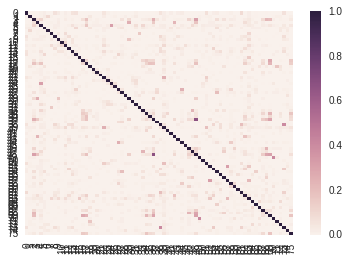

In [7]:
import seaborn as sns
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
cond_sim = cosine_similarity(y.T)
sns.heatmap(cond_sim)

In [9]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=5).fit(vec_represent, y)
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression()).fit(vec_represent, y)

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(clf.predict(vec_represent), y)

0.56019171130532841

In [8]:
import cloudpickle
with open("forum_vectorizer.pkl", 'wb') as handle:
    cloudpickle.dump(d2v_vectorizer, handle)
with open("forum_vecrepresent.pkl", 'wb') as handle:
    cloudpickle.dump(vec_represent, handle)
with open("disease_similarity.pkl", 'wb') as handle:
    cloudpickle.dump(cond_sim, handle)

In [11]:
with open("forum_classifier.pkl", 'wb') as handle:
    cloudpickle.dump(clf, handle)